# 実験1: 各情報量の性質 → パラメータを変えて実験
結果: 差がある、ない、1つの図で比較して見られる


In [ ]:
import numpy as np
from numpy.linalg import det
import var

def create_data():
    N = 2
    for d in np.arange(0, 1.0, 0.2):
        A = np.array([[0.03, d], [d, 0.03]])
        SigmaE = np.array([[0.2, 0.03], [0.03, 0.2]])

        initiali_state = np.random.multivariate_normal([0] * N, np.eye(N,N) * 0.1, size=1)[0]
        state_list = var.generate(initiali_state, A, SigmaE, N=10000)
        SigmaX = np.cov(state_list.T)
        yield {
            "d": d,
            "A": A,
            "SigmaE": SigmaE,
            "SigmaX": SigmaX,
            "state_list": state_list,
            "N": N,
            "mask": np.eye(N, N),
            "MI": 1 / 2 * np.log(det(SigmaX) / det(SigmaE))
        }

In [ ]:
import gaii
import geoii
import pandas as pd
from IPython.display import display
result = []
for data in create_data():
    N = data["N"]
    model_gaii = gaii.fit_q(data["state_list"], data["mask"])
    gaii_result = model_gaii["js"]

    model_geoii = geoii.fit_q(data["A"], data["SigmaE"], data["SigmaX"], data["mask"])
    geoii_result = model_geoii["kl"]

    MI = data["MI"]
    print((MI, gaii_result, geoii_result))
    result.append((MI, gaii_result, geoii_result))
result = pd.DataFrame(result, columns=["MI", "gaii", "geoii"])
display(result)
result.plot()

# 実験2: 属性をクラスタリングできる

In [ ]:
import numpy as np
from numpy.linalg import det
import var

def create_data():
    N = 4
    A = np.array([
        [0.4, 0.4, 0, 0],
        [0.4, 0.4, 0, 0],
        [0, 0, 0.4, 0.4],
        [0, 0, 0.4, 0.4],
    ])
    L = np.eye(N,N) * 1 + np.eye(N,N,k=1) * 0.7
    SigmaE = L @ L.T

    initiali_state = np.random.multivariate_normal([0] * N, np.eye(N,N) * 0.1, size=1)[0]
    state_list = var.generate(initiali_state, A, SigmaE, N=10000)
    SigmaX = np.cov(state_list.T)
    return {
        "A": A,
        "SigmaE": SigmaE,
        "SigmaX": SigmaX,
        "state_list": state_list,
        "N": N,
        "mask": np.eye(N, N),
        "MI": 1 / 2 * np.log(det(SigmaX) / det(SigmaE))
    }

In [ ]:
import gaii
import geoii
import pandas as pd
from IPython.display import display
import mip
data = create_data()
candidate_masks, candidate_list = mip.generate_masks(set(range(4)))

result = []
for mask in candidate_masks:
    N = data["N"]
    model_gaii = gaii.fit_q(data["state_list"], mask)
    gaii_result = model_gaii["js"]

    model_geoii = geoii.fit_q(data["A"], data["SigmaE"], data["SigmaX"], mask)
    geoii_result = model_geoii["kl"]

    MI = data["MI"]
    print((MI, gaii_result, geoii_result))
    result.append((MI, gaii_result, geoii_result))

result = pd.DataFrame(result, columns=["MI", "gaii", "geoii"], index=candidate_list)
display(result)
ax = result.plot()
ax.tick_params(axis='x', rotation=70)
ax

# 実験3: 実データで試してみた

In [ ]:
from statsmodels.tsa.api import VAR
def create_data():
    table = pd.read_table("stats.tsv", index_col="Date")
    display(table)
    table[["jp", "fr", "ge"]].plot()
    
    table_pct = table.pct_change()[["jp", "fr", "ge"]]
    table_pct.plot()
    table_pct = table_pct[1:-1].to_numpy()
    
    N = 3
    ar = VAR(table_pct).fit(trend="n", maxlags=1)
    initiali_state = np.random.multivariate_normal([0] * N, np.eye(N,N) * 0.01, size=1)[0]
    state_list = var.generate(initiali_state, ar.params, ar.sigma_u, N=10000)
    SigmaX = np.cov(state_list.T)
    return {
        "N": N,
        "A": ar.params,
        "SigmaE": ar.sigma_u,
        "SigmaX": SigmaX,
        "state_list": table_pct,
        "N": N,
        "mask": np.eye(N, N),
        "MI": 1 / 2 * np.log(det(SigmaX) / det(ar.sigma_u))
    }

data = create_data()
import mip
import gaii
import geoii
import pandas as pd
from IPython.display import display

N = data["N"]
candidate_masks, candidate_list = mip.generate_masks(set(range(N)))
result = []
for mask in candidate_masks:
    model_gaii = gaii.fit_q(data["state_list"], mask)
    gaii_result = model_gaii["js"]

    model_geoii = geoii.fit_q(data["A"], data["SigmaE"], data["SigmaX"], mask)
    geoii_result = model_geoii["kl"]

    MI = data["MI"]
    print((MI, gaii_result, geoii_result))
    result.append((MI, gaii_result, geoii_result))

result = pd.DataFrame(result, columns=["MI", "gaii", "geoii"], index=candidate_list)
display(result)
ax = result.plot()
ax.tick_params(axis='x', rotation=70)

# 実験４: 長期記憶のあるネットワークの利用

In [30]:
import numpy as np
from numpy.linalg import det
import var

def create_data():
    N = 4
    A = np.array([
        [0.4, 0.4, 0, 0],
        [0.4, 0.4, 0, 0],
        [0, 0, 0.4, 0.4],
        [0, 0, 0.4, 0.4],
    ])
    L = np.eye(N,N) * 1 + np.eye(N,N,k=1) * 0.7
    SigmaE = L @ L.T

    initiali_state = np.random.multivariate_normal([0] * N, np.eye(N,N) * 0.1, size=1)[0]
    state_list = var.generate(initiali_state, A, SigmaE, N=10000)
    SigmaX = np.cov(state_list.T)
    return {
        "A": A,
        "SigmaE": SigmaE,
        "SigmaX": SigmaX,
        "state_list": state_list,
        "N": N,
        "mask": np.eye(N, N),
        "MI": 1 / 2 * np.log(det(SigmaX) / det(SigmaE))
    }

In [31]:
import importlib
importlib.reload(gaii_dnn)

<module 'gaii_dnn' from '/Users/sasano/gaii/src/gaii_dnn.py'>

([0], [1, 2, 3])
Generator(
  (activation): ReLU()
  (linear1_1): Linear(in_features=4, out_features=4, bias=True)
  (linear2_1): Linear(in_features=12, out_features=12, bias=True)
  (linear1_2): Linear(in_features=4, out_features=4, bias=True)
  (linear2_2): Linear(in_features=12, out_features=12, bias=True)
)
Discriminator(
  (activation): ReLU()
  (linear1): Linear(in_features=16, out_features=16, bias=True)
  (linear2): Linear(in_features=16, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
[Count 0/20000]    [JS: 0.009230] [G loss: 1.507757] [D loss: 1.367835]
[Count 100/20000]    [JS: 0.028043] [G loss: 1.576872] [D loss: 1.330208]
[Count 200/20000]    [JS: 0.047185] [G loss: 1.619249] [D loss: 1.291924]
[Count 300/20000]    [JS: 0.070966] [G loss: 1.710095] [D loss: 1.244363]
[Count 400/20000]    [JS: 0.088405] [G loss: 1.778691] [D loss: 1.209485]
[Count 500/20000]    [JS: 0.110012] [G loss: 1.867752] [D loss: 1.166269]
[Count 600/20000]    [JS: 0.136466] [G loss: 1.964735] 

,MI,gaii,geoii
"({0}, {1, 2, 3})",1.107158,0.235464,7.045237e-01
"({1}, {0, 2, 3})",1.107158,0.323754,8.449102e-01
"({2}, {0, 1, 3})",1.107158,0.453740,5.592808e-01
"({3}, {0, 1, 2})",1.107158,0.353753,4.901411e-01
"({0, 1}, {2, 3})",1.107158,0.139173,5.960464e-08
"({0, 2}, {1, 3})",1.107158,0.414255,5.583875e-01
"({0, 3}, {1, 2})",1.107158,0.449629,4.443828e-01


<AxesSubplot:>

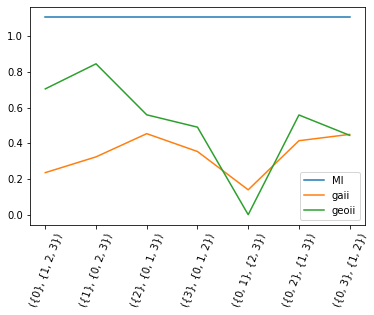

In [32]:
import gaii_dnn
import geoii
import pandas as pd
from IPython.display import display
import mip
data = create_data()
candidate_masks, candidate_list = mip.generate_masks(set(range(4)))

result = []
for mask, ls in zip(candidate_masks, candidate_list):
    N = data["N"]
    ls = (list(ls[0]), list(ls[1]))
    print(ls)
    model_gaii = gaii_dnn.fit_q(data["state_list"], ls, length=4, debug=True)
    gaii_result = model_gaii["js"]

    model_geoii = geoii.fit_q(data["A"], data["SigmaE"], data["SigmaX"], mask)
    geoii_result = model_geoii["kl"]

    MI = data["MI"]
    print((MI, gaii_result, geoii_result))
    result.append((MI, gaii_result, geoii_result))

result = pd.DataFrame(result, columns=["MI", "gaii", "geoii"], index=candidate_list)
display(result)
ax = result.plot()
ax.tick_params(axis='x', rotation=70)
ax

In [2]:
!pip install torchinfo

You should consider upgrading via the '/Users/sasano/gaii/.venv/bin/python -m pip install --upgrade pip' command.
